### Download GRACE RL06 Dataset

In [ ]:
!curl "http://download.csr.utexas.edu/outgoing/grace/RL06_mascons/CSR_GRACE_GRACE-FO_RL06_Mascons_all-corrections_v02.nc" -o GRACE_RL06_Mascons.nc

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  759M  100  759M    0     0  10.8M      0  0:01:09  0:01:09 --:--:-- 11.2M


In [ ]:
!python -m pip install netCDF4

     |████████████████████████████████| 4.3MB 9.3MB/s 
     |████████████████████████████████| 296kB 32.2MB/s 


### Load dataset & explore it

In [ ]:
import netCDF4
import numpy as np

import tensorflow as tf
from tensorflow import keras

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [ ]:
f = netCDF4.Dataset('/content/GRACE_RL06_Mascons.nc')
print(f)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.6, ACDD-1.3, ISO 8601
    filename: netcdf/CSR_GRACE_GRACE-FO_RL06_Mascons_all-corrections_v02.nc
    Metadata_Conventions: Unidata Dataset Discovery v1.0
    standard_name_vocabulary: NetCDF Climate and Forecast (CF) Metadata Convention-1.6
    title: CSR GRACE and GRACE-FO MASCON RL06Mv2
    summary: Monthly mass anomaly grids from GRACE and GRACE-FO determined from CSR RL06 processing
    keywords: Solid Earth, Geodetics/Gravity, Gravity, liquid_water_equivalent_thickness
    keywords_vocabulary: NASA Global Change Master Directory (GCMD) Science Keywords
    platform: GRACE and GRACE-FO
    institution: The University of Texas - Center for Space Research (CSR)
    creator_name: Himanshu Save
    creator_email: grace@csr.utexas.edu
    creator_url: http://www2.csr.utexas.edu/grace
    creator_type: group
    creator_institution: UT-CSR
    publisher_name: 
    publishe

In [ ]:
print(f.variables.keys())

odict_keys(['lat', 'lon', 'time', 'time_bounds', 'lwe_thickness'])


In [ ]:
lt, ln = f.variables['lat'], f.variables['lon']

In [ ]:
w = f.variables['lwe_thickness']
print(w)

<class 'netCDF4._netCDF4.Variable'>
float32 lwe_thickness(time, lat, lon)
    units: cm
    long_name: Liquid_Water_Equivalent_Thickness
    standard_name: Liquid_Water_Equivalent_Thickness
    coordinates: time lat lon
    grid_mapping: WGS84
unlimited dimensions: 
current shape = (187, 720, 1440)
filling on, default _FillValue of 9.969209968386869e+36 used


In [ ]:
def getclosestindex(vs,v):
    dist_sq = (vs-v)**2
    minindex_flattened = dist_sq.argmin()
    return minindex_flattened

## Enter Location

In [ ]:
# Input loc here
RUN = 0

loc = "Harirampur"

input_lt, input_ln = 23.746481, 89.973992

latvals = lt[:]
lonvals = ln[:]

xc = getclosestindex(latvals, input_lt)
yc = getclosestindex(lonvals, input_ln)

print(loc)
print((xc, yc))
print(lt[xc],ln[yc])

Harirampur
(454, 359)
23.625 89.875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: WARNING: valid_max not used since it
ca

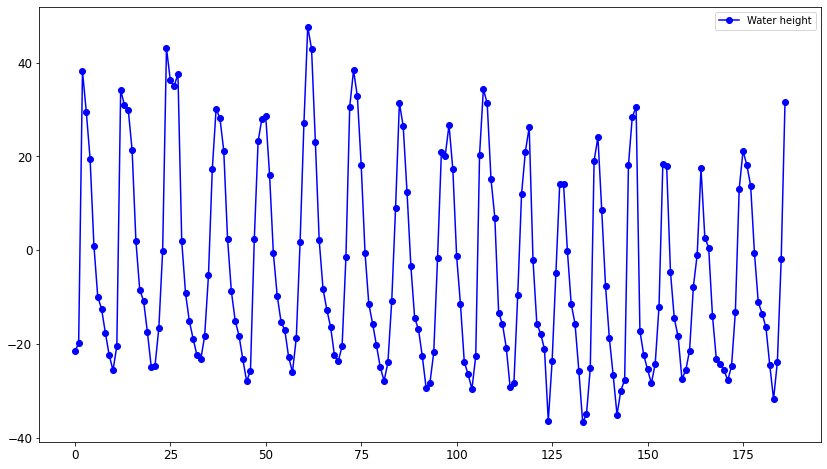

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(14,8))
plt.plot(w[:, xc, yc], label="Water height", marker="o", color="Blue")
plt.legend()
plt.savefig("WL.png", dpi=120)

In [ ]:
Mn = np.array([e for e in w[:, xc, yc]]).min()

elev = abs(Mn)
print("Elevation: "+ str(elev))

Mx = np.array([e+elev for e in w[:, xc, yc]]).max()
print("Maximum Water Level: "+str(Mx))

Elevation: 36.666748
Maximum Water Level: 84.351265


## Train the model

In [ ]:
# univariate multi-step vector-output 1d cnn example
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
raw_seq = np.array([e+elev for e in w[:, xc, yc]])
# choose a number of time steps
n_steps_in, n_steps_out = 24, 12
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=6, activation="relu", input_shape=(n_steps_in, n_features)))
#model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
#model.add(Dense(64, activation='relu'))
model.add(Dense(n_steps_out, activation='relu'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002), loss="mse")

In [ ]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 19, 64)            448       
_________________________________________________________________
flatten_16 (Flatten)         (None, 1216)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 12)                14604     
Total params: 15,052
Trainable params: 15,052
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model
model.fit(X, y, epochs=1500, verbose=0)

# demonstrate prediction
x_input = np.array([e+elev for e in w[-24:, xc, yc]])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)

In [ ]:
Prev12M = [e+elev for e in w[-12:, xc, yc]]

Prev12M

[57.846626,
 54.84926,
 50.421925,
 36.022297,
 25.516762,
 23.131443,
 20.226965,
 12.199368,
 4.8563023,
 12.86101,
 34.71439,
 68.36354]

In [ ]:
ymax, ymin, predictions = yhat[0].max(), yhat[0].min(), yhat[0].tolist()

print(ymax)
print(str(ymin) + "\n")
print(loc)
predictions

85.51656
1.9402977

Harirampur


[85.51656341552734,
 70.71150970458984,
 50.05242156982422,
 37.78590774536133,
 17.202346801757812,
 5.389642715454102,
 1.9402977228164673,
 12.844430923461914,
 17.549715042114258,
 18.95379066467285,
 30.784414291381836,
 53.87975311279297]

## Make an average collection of predictios

In [ ]:
if RUN == 0:
  final = [0.0 for e in predictions]
  final = [sum(x) for x in zip(final, predictions)]
  RUN = RUN + 1
else:
  final = [sum(x)/2 for x in zip(final, predictions)]
  RUN = RUN + 1

print("Predicted " + str(RUN) + " times")
final

Predicted 17 times


[83.37566241575405,
 68.10781823430443,
 46.66033368738135,
 31.250284317298792,
 15.193101763710729,
 6.688665953792224,
 6.897194126224349,
 15.26225351508765,
 20.40602161566494,
 21.289049958024407,
 30.435730018507456,
 47.45964926073793]

## Final values

In [ ]:
# final averaged predictions

fmax, fmin = np.array(final).max(), np.array(final).min()

print("Predicted " + str(RUN) + " times")
print(fmax)
print(str(fmin) + "\n")
print("\""+loc+"\" : ")
final

Predicted 17 times
83.37566241575405
6.688665953792224

"Harirampur" : 


[83.37566241575405,
 68.10781823430443,
 46.66033368738135,
 31.250284317298792,
 15.193101763710729,
 6.688665953792224,
 6.897194126224349,
 15.26225351508765,
 20.40602161566494,
 21.289049958024407,
 30.435730018507456,
 47.45964926073793]

In [ ]:
Next12M = {
    "Harirampur" : [83.37566241575405,
 68.10781823430443,
 46.66033368738135,
 31.250284317298792,
 15.193101763710729,
 6.688665953792224,
 6.897194126224349,
 15.26225351508765,
 20.40602161566494,
 21.289049958024407,
 30.435730018507456,
 47.45964926073793],
    "Char Bhadrasan" : [80.71582370019678,
 64.45147470239317,
 47.4994008244139,
 27.414131754469963,
 14.777316424215542,
 5.779952143052924,
 6.362640218538218,
 8.503402656722642,
 19.39567007214282,
 26.145970935112928,
 38.080850218791966,
 47.923729835769336],
    "Bhairab" : [92.76574045419693,
 85.53009076416492,
 61.293516740202904,
 40.09601981192827,
 26.129730135202408,
 18.39254019409418,
 7.884874705225229,
 11.734869399573654,
 26.62385232001543,
 38.101862378418446,
 50.934791542589664,
 73.4457064718008],
    "Belkuchi" : [65.43549466133118,
 57.81847321987152,
 41.981318950653076,
 25.848386257886887,
 22.760776847600937,
 24.180132552981377,
 6.844019219279289,
 18.692757785320282,
 32.48228847980499,
 38.29881113767624,
 42.47589319944382,
 53.15636157989502],
    "Kazipur" : [75.8254815086666,
 58.415705766317096,
 32.01911318464689,
 10.532982360453403,
 6.6451897275797,
 5.599301043576381,
 1.1936809986363917,
 18.94305079976961,
 49.50866488577469,
 61.255045159823716,
 50.941823546632996,
 37.664123059579346],
    "Islampur" : [81.08903377996467,
 55.12918073878245,
 28.193739237573027,
 13.887987718298973,
 3.404777561086121,
 4.977645838659555,
 3.2189345254382715,
 19.308210690305714,
 48.980617966466525,
 64.22145823459869,
 48.09792255736829,
 37.990922936442075],
    "Tarakandi" : [84.1515289824456,
 64.12938704201952,
 30.719740419182926,
 12.339830142911524,
 9.744849334820174,
 3.729831181903137,
 6.120846617617644,
 23.20267743052682,
 43.487701014149934,
 57.79576760157943,
 57.343095482792705,
 44.87807603972033],
    "Sunamganj" : [82.44949231296778,
 72.87413647770882,
 46.74524584040046,
 28.76473619788885,
 9.811822448857129,
 3.7647783951833844,
 4.340537782758474,
 6.313884114380926,
 44.30940032750368,
 63.31514361128211,
 63.17005091533065,
 64.71387718245387],
    "Balinga" : [79.61154901071131,
 74.56208812406476,
 60.06174039722828,
 39.861757088567174,
 27.361492887253007,
 20.06723764887647,
 11.285489656978825,
 3.9204509408138506,
 23.046171237906947,
 33.68371448007019,
 50.75960865702109,
 64.38164805951237],
    "Atrai" : [69.34085276616679,
 56.9931471075397,
 36.7508026021751,
 22.552473047860985,
 12.262031623784424,
 14.81468595503884,
 8.716837317512272,
 26.57263489950128,
 31.985794663782144,
 41.55651758759632,
 44.00163923650689,
 47.995317956498184],
    "Naogaon" : [70.01910763955675,
 62.79368197027361,
 35.267329587368295,
 15.19845852110302,
 15.22792416716402,
 9.843754888919648,
 3.9769008766415936,
 26.116543400348746,
 37.52913634953438,
 22.453295559622347,
 46.655036418524105,
 48.998413856024854],
    "Mohadevpur" : [66.41108023526613,
 55.030660681193694,
 39.30752526392462,
 24.467732183780754,
 16.51312490804412,
 10.698321891657542,
 6.25928350319009,
 26.105978354782565,
 36.32635830598883,
 38.95868481800426,
 37.74268990266137,
 43.91615949769039],
    "Kamarkhali" : [81.13771277666092,
 66.32918602228165,
 40.287062384188175,
 23.498603258281946,
 9.791521093808115,
 5.090513443574309,
 8.504864090122283,
 16.364825977012515,
 19.997877690941095,
 27.15374445915222,
 36.082820288836956,
 52.0763935148716],
    "Bhagyakul" : [77.47495194897056,
 65.22943885810673,
 49.311301128938794,
 28.807174157351255,
 11.526218730956316,
 9.069746691500768,
 11.37678056024015,
 14.118413474876434,
 18.712198132183403,
 23.863998474087566,
 29.040098344907165,
 48.443070827052],
    "Goalanda" : [75.96311669796705,
 65.10154354572296,
 48.34109588712454,
 29.063707657158375,
 16.403027184307575,
 13.001834093593061,
 12.203746506012976,
 9.935860390774906,
 11.469066189602017,
 20.34034239128232,
 29.7537951618433,
 46.44406292960048],
    "Hatibanda" : [19.82246546447277,
 15.640085309743881,
 2.3458240926265717,
 8.750309348106384,
 24.716756403446198,
 34.25593752413988,
 4.168946597725153,
 17.8434170037508,
 17.607005504425615,
 47.19111433625221,
 73.94486191868782,
 26.20453980192542],
    "Kakina" : [54.69654580950737,
 32.4006912112236,
 13.674270648509264,
 4.948430173099041,
 6.885215245187283,
 0.21413185447454453,
 0.0,
 22.92406715452671,
 61.07412472367287,
 72.67081344127655,
 61.93119993805885,
 37.70812730491161],
    "Nageshwari" : [57.27353096008301,
 36.84248065948486,
 12.545114994049072,
 3.36492657661438,
 10.221299171447754,
 1.3871290683746338,
 0.0,
 13.7675461769104,
 59.84200859069824,
 72.63076400756836,
 69.13946151733398,
 37.448668479919434],
     "Rowmari" : [71.9682731628418,
 40.49336051940918,
 29.13720989227295,
 23.893017768859863,
 7.182333469390869,
 0.0,
 0.0,
 27.246127128601074,
 67.87415313720703,
 70.97156715393066,
 51.36223602294922,
 38.178720474243164],
 "Ulipur" : [43.33977937698364,
 29.74267578125,
 7.088576540350914,
 7.87835693359375,
 5.2287837266922,
 0.6866019368171692,
 0.0,
 18.019670724868774,
 53.513662815093994,
 69.45811748504639,
 64.53265523910522,
 27.0439236164093],
 "Chilmari" : [52.630002930760384,
 26.67014385201037,
 11.280132064595819,
 1.79543881455902,
 15.348645506892353,
 4.419343572575599,
 0.0,
 12.826442742720246,
 45.84507818520069,
 62.81911766529083,
 67.33414650335908,
 34.54388199746609],
 "Kharkharia" : [59.48935332894325,
 29.551391288638115,
 13.220338113605976,
 8.495796166360378,
 8.115448907017708,
 1.1281001511961222,
 0.22686901688575745,
 24.859148047864437,
 40.88560751080513,
 68.9762496650219,
 66.24917623400688,
 27.740341693162918],
 "Polashi" : [64.25638686865568,
 39.35907119931653,
 16.482505910098553,
 12.321766234003007,
 5.870259107556194,
 0.780464768409729,
 0.0,
 17.297518538311124,
 52.01433837413788,
 69.66305308043957,
 62.5959839373827,
 36.51613324135542],
}

In [ ]:
import json

with open('Next12M.json', 'w') as json_file:
  json.dump(Next12M, json_file)

This work was done by **Shahriar Shanto** <br>
for NASA Space Apps Challenge 2020 <br>
https://flood-predict.herokuapp.com